# 데이터 가져오기

In [7]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

import FinanceDataReader as fdr
import pandas as pd

code_dict = {
    'TIGER 200': '102110',
    'TIGER 미국S&P500선물(H)': '143850',
    'KINDEX 중국본토CSI300': '168580',
    'KODEX 골드선물(H)': '132030',
    'KOSEF 미국달러선물': '138230',
    'KOSEF 국고채10년': '148070'
}

In [8]:
# 종가 데이터프레임을 만듭니다. (2013~2018)

start_date = '2013-01-01'
end_date = '2020-01-01'
a = {}
for name in code_dict:
    try:
        code = code_dict[name]        
        a[name] = fdr.DataReader(code, start=start_date, end=end_date)['Close']
        print(name)
    except:
        pass

price_table = pd.DataFrame(a)

TIGER 200
TIGER 미국S&P500선물(H)
KINDEX 중국본토CSI300
KODEX 골드선물(H)
KOSEF 미국달러선물
KOSEF 국고채10년


In [3]:
# 벤치마크로 사용할 지표도 가져옵니다.
benchmark = fdr.DataReader('KS11', start=start_date, end=end_date)['Close']

In [9]:
# 아래와 같이, 일별로 종가가 담겨 있는 표를 만들었습니다.
price_table

,TIGER 200,TIGER 미국S&P500선물(H),KINDEX 중국본토CSI300,KODEX 골드선물(H),KOSEF 미국달러선물,KOSEF 국고채10년
Date,,,,,,
2013-01-02,23524,15220,13390,12975,10727,92628
2013-01-03,23423,15495,13555,13020,10709,93182
2013-01-04,23304,15450,13210,12745,10727,93186
2013-01-07,23342,15560,13210,12790,10732,93308
2013-01-08,23102,15470,13220,12730,10727,93608
...,...,...,...,...,...,...
2019-12-23,28986,37825,23030,10575,12305,123163
2019-12-24,28799,37845,23100,10655,12300,123363
2019-12-26,28893,37880,23235,10745,12280,123290


누락값이 많은 데이터는 제외하겠습니다.

In [10]:
# 이 경우에는 누락값이 없네요.
price_table.isnull().sum()

TIGER 200              0
TIGER 미국S&P500선물(H)    0
KINDEX 중국본토CSI300      0
KODEX 골드선물(H)          0
KOSEF 미국달러선물           0
KOSEF 국고채10년           0
dtype: int64

In [11]:
# 누락값이 있는 경우 아래와 같이 처리해줄 수 있습니다.
# 누락값이 10보다 많은 종목은 삭제합니다.
dropThis = price_table.columns[df.isnull().sum() > 10]
price_table = price_table.drop(dropThis, axis=1)

# 남아 있는 누락값은 전날의 데이터로 채워넣겠습니다.
price_table = price_table.fillna(method='ffill')

# 포트폴리오 만들기

종목별 투자 비중과 투자액을 입력하면 포트폴리오 가치를 일별로 계산해주는 함수를 만듭니다. 

예를 들어 투자 비중이 `weight`에 담겨 있다고 하겠습니다. 전체 투자 금액은 100원입니다.

```python
# 3개 종목에 50%, 20%, 30%씩 투자하는 포트폴리오
weight = np.array([0.5, 0.2, 0.3])

# 투자 금액(현금)은 1000원
cash = 1000
```

이 경우, 각 종목당 투자금액은 `weight`와 `cash`의 원소별 곱셈을 하면 구할 수 있습니다.

```python
weight * cash
>>> array([500., 200., 300.])
```

투자 금액을 주당 가격으로 나누면, 각 종목을 몇 주 사야 하는지가 계산됩니다.

그러나 1번 종목에 500원을 투자하고 싶어도, 1주의 가격으로 딱 나누어 떨어지지 않을 수 있습니다. 

그렇기 때문에 소수점 이하는 무시하겠습니다.

```python
prices = np.array([28, 100, 33])
weight * cash // prices # 종목별 구매 개수를 산출합니다.
>>> array([17.,  2.,  9.])

```

구매 개수와 가격을 곱하면, 종목별 실제 투자 금액이 산출됩니다.

```
weight * cash // prices * prices
>>> array([476., 200., 297.])
```

소수점 이하를 버림으로써 남게 되는 금액은 현금으로 보유하는 것으로 하겠습니다.

In [22]:
# 이를 함수로 만들겠습니다.

def portfolio_values(price_table, weight, cash):
    nstocks = (cash * weight) // price_table.iloc[0]
    port_table = price_table * nstocks
    
    # 주식에 투자한 액수
    stock_amount = port_table.sum(axis=1)
    # 현금으로 보유하는 액수
    cash_amount = cash - stock_amount.iloc[0]
    # 총 자산 가치
    total_amount = stock_amount+cash_amount
    
    port_table['cash'] = cash_amount
    port_table['portfolio'] = total_amount
    return port_table

# 초기 투자 금액
cash = 5000000   

# 동일한 비중으로 투자한 경우
n = price_table.shape[1]
w = np.ones(n) / n

portfolio_values(price_table, w, cash)

,TIGER 200,TIGER 미국S&P500선물(H),KINDEX 중국본토CSI300,KODEX 골드선물(H),KOSEF 미국달러선물,KOSEF 국고채10년,cash,portfolio
Date,,,,,,,,
2013-01-02,823340.0,821880.0,830180.0,830400.0,825979.0,741024.0,127197.0,5000000.0
2013-01-03,819805.0,836730.0,840410.0,833280.0,824593.0,745456.0,127197.0,5027471.0
2013-01-04,815640.0,834300.0,819020.0,815680.0,825979.0,745488.0,127197.0,4983304.0
2013-01-07,816970.0,840240.0,819020.0,818560.0,826364.0,746464.0,127197.0,4994815.0
2013-01-08,808570.0,835380.0,819640.0,814720.0,825979.0,748864.0,127197.0,4980350.0
...,...,...,...,...,...,...,...,...
2019-12-23,1014510.0,2042550.0,1427860.0,676800.0,947485.0,985304.0,127197.0,7221706.0
2019-12-24,1007965.0,2043630.0,1432200.0,681920.0,947100.0,986904.0,127197.0,7226916.0
2019-12-26,1011255.0,2045520.0,1440570.0,687680.0,945560.0,986320.0,127197.0,7244102.0


# 동일 가중 포트폴리오 구하기

2015-2019년 5년 동안 투자를 하는 경우를 보겠습니다.

In [24]:
# date_range 함수를 사용할 것입니다.
pd.date_range('2014-12-01', '2019-12-31', freq='3M')

DatetimeIndex(['2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30',
               '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30',
               '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30',
               '2019-12-31'],
              dtype='datetime64[ns]', freq='3M')

In [25]:
# freq 인자에 어떤 게 들어갈 수 있는지는 1주차의 resample 함수 설명을 참조해주세요.
pd.date_range('2015-01-01', '2019-12-31', freq='3MS')

DatetimeIndex(['2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01'],
              dtype='datetime64[ns]', freq='3MS')

In [23]:
import datetime as dt

# 초기 투자 금액 설정
cash = 50000000

# 리밸런싱할 날짜 설정 (3달 1회)
dates = pd.date_range('2015-01-01', '2025-01-01', freq='3MS')

ports = []
i = 0
while True:
    start_date = dates[i]
    end_date = dates[i+1]
    
    # 어떤 가중치로 리벨런싱할 것인지 설정
    w = np.ones(n) / n
    
    # 전체 종가 테이블 중에서 투자하는 기간만 잘라서 본다.
    df_slice = price_table[start_date:end_date]
    
    # 3개월 동안의 포트폴리오 가치 편화를 ports 변수에 모은다.
    ports.append(portfolio_values(df_slice, w, cash))
    
    # 다음 기간의 투자금액은 이전 기간에 가지고 있는 총 자산 가치가 된다.
    cash = ports[-1].iloc[-1, -1]
    i += 1
    
    # 언제 while문을 탈출할 것인지 조건 설정
    if end_date >= dt.datetime(2020, 1, 1):
        break

# 전체 결과를 하나로 합칩니다.
port = pd.concat(ports)
equal_port = port['portfolio']

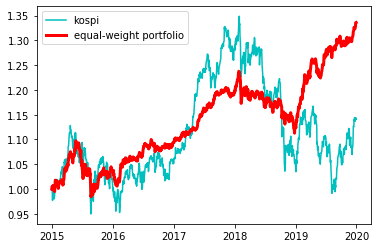

In [26]:
# 벤치마크 대비 포트폴리오를 수익률을 그려봅시다.

import matplotlib.pyplot as plt

start_date = equal_port.index[0]
plt.plot(benchmark.loc[start_date:] / benchmark.loc[start_date], color='c', label='kospi')
plt.plot(equal_port / equal_port.loc[start_date], linewidth=3, color='r', label='equal-weight portfolio')
plt.legend()
plt.show()

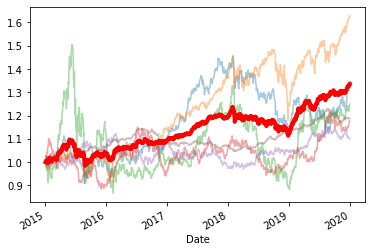

In [27]:
# 개별 ETF 대비한 수익률도 그려보겠습니다.

start_date = equal_port.index[0]

(price_table.loc[start_date:] / price_table.loc[start_date]).plot(legend=False, alpha=0.4)
plt.plot(equal_port / equal_port.loc[start_date], linewidth=4, color='r')
plt.show()

# 최적화를 이용한 포트폴리오 비중 구하기

기대수익률, 공분산 행렬, 목표 수익률을 넣으면 목표 수익률 하에서 분산을 최소로 하는 포트폴리오 비중을 반환하는 함수를 정의해주겠습니다.

이 함수는 반복해서 활용됩니다.

시간이 변함에 따라 기대수익률과 종목 간의 상관관계가 달라집니다. 시간 변화에 따라 새롭게 구한 기대수익률과 공분산 행렬을 이 함수에 넣으면, 그에 따른 최적화된 비중을구할 수 있습니다.

In [28]:
def ObjFunction(w, cov):
    var = cov.dot(w).dot(w)
    return var

def jac_m(w, cov):
    return 2*cov.dot(w)

def optimal_weight(exp_returns, cov, target_return=None, short=False):

    n_stocks = cov.shape[0]
    w_init = np.ones(n_stocks) / n_stocks
    
    c_ = [{'type':'eq', 'fun': lambda w: sum(w)-1. }]
    if target_return != None:
        c_ += [{'type':'eq', 'fun': lambda w: exp_returns.dot(w)-target_return}]
        
    if short:
        b_ = None
    else:
        b_ = [(0,1) for i in range(n_stocks)]
        
    res = optimize.minimize(ObjFunction, w_init, cov, jac=jac_m, constraints=c_, bounds=b_, tol=1e-20)
    return res.x

# 기대 수익률, 공분산 계산하기

이번에는 날짜를 입력으로 받아서, 해당 날짜에 기대할 수 있는 수익률과 공분산을 반환하는 함수를 만들 것입니다.

과거 6개월치 데이터를 이용해서 기대 수익률과 공분산 행렬을 구할 것입니다.

In [63]:
import datetime as dt

def calulate_mean_covariance(data, date):

    datefrom = date - dt.timedelta(days=30*6)
    return_mat = data.pct_change(20)[datefrom:date]
    # 월 수익률을 계산한 뒤 연 단위로 환산해줍니다.
    exp_ret = return_mat.mean()*12
    cov = return_mat.cov()*12
    return exp_ret, cov

# 백테스트 하기

In [64]:
import datetime as dt

cash = 500000000
dates = pd.date_range('2015-01-01', '2025-01-01', freq='3MS')

ports = []
i = 0
while True:
    start_date = dates[i]
    end_date = dates[i+1]

    # 동일 가중 포트폴리오에서 아래 부분만 바뀌었습니다. (가중치 계산 부분만 바뀌었습니다)
    exp_ret, cov = calulate_mean_covariance(df, start_date)
    w = optimal_weight(exp_ret, cov, short=True)
    #######################################################
    
    df_slice = df[start_date:end_date]
    
    ports.append(portfolio_values(df_slice, w, cash))
    
    cash = ports[-1].iloc[-1, -1]
    i += 1
    
    if end_date >= dt.datetime(2020, 1, 1):
        break
        
port = pd.concat(ports)
port_value = port['portfolio']

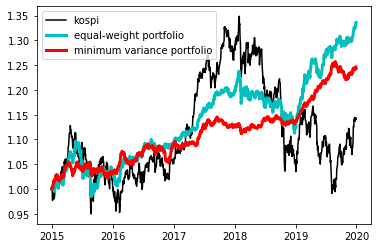

In [65]:
import matplotlib.pyplot as plt

start_date = port.index[0]

plt.plot(benchmark.loc[start_date:] / benchmark.loc[start_date], color='k', label='kospi')
plt.plot(equal_port / equal_port.loc[start_date], linewidth=3, color='c', label='equal-weight portfolio')
plt.plot(port_value / port_value.loc[start_date], linewidth=3, color='r', label='minimum variance portfolio')
plt.legend()
plt.show()

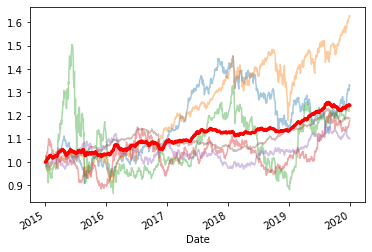

In [66]:
# 변동성을 최소로 만드는 포트폴리오입니다.
(df.loc[start_date:] / df.loc[start_date]).plot(legend=False, alpha=0.4)
plt.plot(port_value / port_value.loc[start_date], linewidth=3, color='r')
plt.show()

# 효율적 경계선 구하기

기대수익률과 공분산 행렬이 주어지면, 해당 수익률과 공분산 하에서 구성할 수 있는 포트폴리오의 수익률-표준편차 집합을 그려볼 수 있습니다.

참고로 기대수익률과 공분산 행렬은 미래에 대한 추정치입니다. 위의 예제에서는 과거 6개월 수익률 평균으로 "미래에도 이 정도 수익률을 기대할 수 있다"고 추정했습니다. 이는 과거의 경향이 미래에도 어느 정도 지속될 것이란 생각이 반영되어 있습니다. 일반적으로 과거 종가 데이터로 분산(변동성)을 추정하는 것은 미래의 수익률을 추정하는 것에 비해 오차가 적습니다.

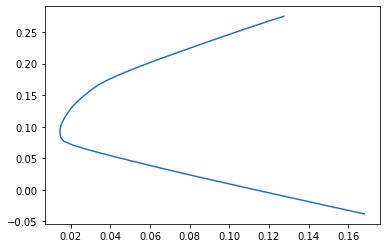

In [78]:
means = []
stds = []
for t in np.linspace(exp_ret.min(), exp_ret.max()):
    w = optimal_weight(exp_ret, cov, t)
    r = exp_ret.dot(w)
    var = cov.dot(w).dot(w)
    std = np.sqrt(var)
    
    means.append(r)
    stds.append(std)
    
plt.plot(stds, means)
plt.show()

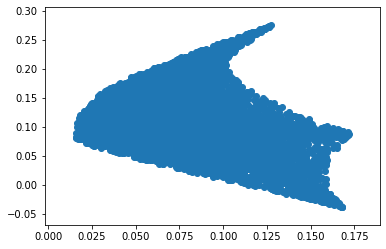

In [108]:
# 최적화를 하지 않고, 랜덤하게 포트폴리오 비중을 정해주면
# 아래와 같이 됩니다.
means = []
stds = []
for p in range (10000):
    
    ### 가중치를 구하는 부분만 바뀌었습니다.
    w = np.random.random(6)**4
    w /= np.sum(w)
    ######################################
    
    r = exp_ret.dot(w)
    var = cov.dot(w).dot(w)
    std = np.sqrt(var)
    means.append(r)
    stds.append(std)
    
plt.scatter(stds, means)
plt.show()

위에서 백테스트한 코드에, 투자집합을 구하는 위 코드만 추가해보겠습니다. 시간에 따라서 투자 기회 집합이 어떻게 변하는지를 관찰해보겠습니다.

In [112]:
import datetime as dt

cash = 500000000
dates = pd.date_range('2015-01-01', '2025-01-01', freq='3MS')

ports = []
i = 0
time_means = []
time_stds = []
while True:
    start_date = dates[i]
    end_date = dates[i+1]

    # 동일 가중 포트폴리오에서 아래 부분만 바뀌었습니다. (가중치 계산 부분만 바뀌었습니다)
    exp_ret, cov = calulate_mean_covariance(df, start_date)
    w = optimal_weight(exp_ret, cov, short=True)
    #######################################################
    
    df_slice = df[start_date:end_date]
    
    ports.append(portfolio_values(df_slice, w, cash))
    
    cash = ports[-1].iloc[-1, -1]
    i += 1
    
    if end_date >= dt.datetime(2020, 1, 1):
        break
        
    means = []
    stds = []
    for p in range (10000):

        ### 가중치를 구하는 부분만 바뀌었습니다.
        w = np.random.random(6)**4
        w /= np.sum(w)
        ######################################

        r = exp_ret.dot(w)
        var = cov.dot(w).dot(w)
        std = np.sqrt(var)
        means.append(r)
        stds.append(std)
    time_means.append(means)
    time_stds.append(stds)
        
port = pd.concat(ports)
port_value = port['portfolio']

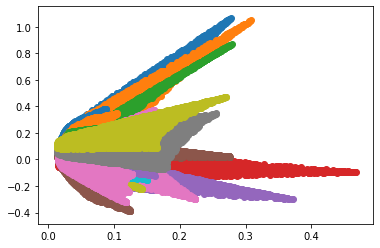

In [117]:
for i in range(len(time_stds)):
    plt.scatter(time_stds[i], time_means[i])
plt.show()